In [199]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from helpers.collection_of_experiments import CollectionOfExperiments
from helpers.plot_helpers import *
from helpers.computational_tools import remesh, gaussian_remesh, select_LatLon, Lk_error, x_coord, y_coord
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean
import os
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")
import hvplot.xarray
import holoviews as hv
import matplotlib as mpl
import cartopy.crs as ccrs
hvplot.output(widget_location='bottom')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
ZBu = xr.open_dataset('/vast/pp2681/ZB2020/ocean_daily.20080101-20121231.ssu.nc', chunks={'time':1})
ZBv = xr.open_dataset('/vast/pp2681/ZB2020/ocean_daily.20080101-20121231.ssv.nc', chunks={'time':1})
ZBT = xr.open_dataset('/vast/pp2681/ZB2020/ocean_daily.20080101-20121231.tos.nc', chunks={'time':1})

In [26]:
loresu = xr.open_dataset('/vast/pp2681/unparameterized/ocean_daily.20080101-20121231.ssu.nc', chunks={'time':1})
loresv = xr.open_dataset('/vast/pp2681/unparameterized/ocean_daily.20080101-20121231.ssv.nc', chunks={'time':1})
loresT = xr.open_dataset('/vast/pp2681/unparameterized/ocean_daily.20080101-20121231.tos.nc', chunks={'time':1})

In [4]:
def KE(u,v,T):
    return 0.5*(remesh(u**2, T) + remesh(v**2,T))

In [5]:
ZBke = KE(ZBu.ssu, ZBv.ssv, ZBT.tos)
loreske = KE(loresu.ssu, loresv.ssv, ZBT.tos)

# Movie
Good interval for time sampling is 5 days. The FPS is 30. An amount of 5-day snapshots is 360+. An amount of longitudes to show is 360.

So we do:
* Movie with 30 FPS, consists of 360 frames
* Every frame we shift longitude by 1 degree

In [6]:
default_rcParams({'figure.subplot.hspace': 0.05, 'font.size': 30})
def plot(idx=0):
    fig, axes = plt.subplots(2,1, figsize=(7, 13), subplot_kw={'projection':ccrs.Orthographic(central_longitude=idx)})
    
    time_idx = idx * 5 # sampling every 5 days
    time_str = loreske.time.isel(time=time_idx).item().strftime('%Y-%m-%d')

    ax = axes[0]
    ax.coastlines(resolution='110m')
    ax.gridlines()
    im = loreske.isel(time=time_idx).plot(
        ax=ax, transform=ccrs.PlateCarree(),
        norm=mpl.colors.LogNorm(vmin=1e-3, vmax=1e+0),
        cmap='inferno',
        add_colorbar=False,
    )
    ax.set_title('$1/4^o$', fontsize=30)

    ax = axes[1]
    ax.coastlines(resolution='110m')
    ax.gridlines()
    im = ZBke.isel(time=time_idx).plot(
        ax=ax, transform=ccrs.PlateCarree(),
        norm=mpl.colors.LogNorm(vmin=1e-3, vmax=1e+0),
        cmap='inferno',
        add_colorbar=False
    )
    ax.set_title('$1/4^o$, ZB2020', fontsize=30)

    cb = plt.colorbar(im, pad=0.02, ax=axes, extend='both', aspect=50, shrink=0.9)
    cb.set_label(label='Surface KE, $\mathrm{m}^2/\mathrm{s}^2$', fontsize=30)
    plt.suptitle(time_str)

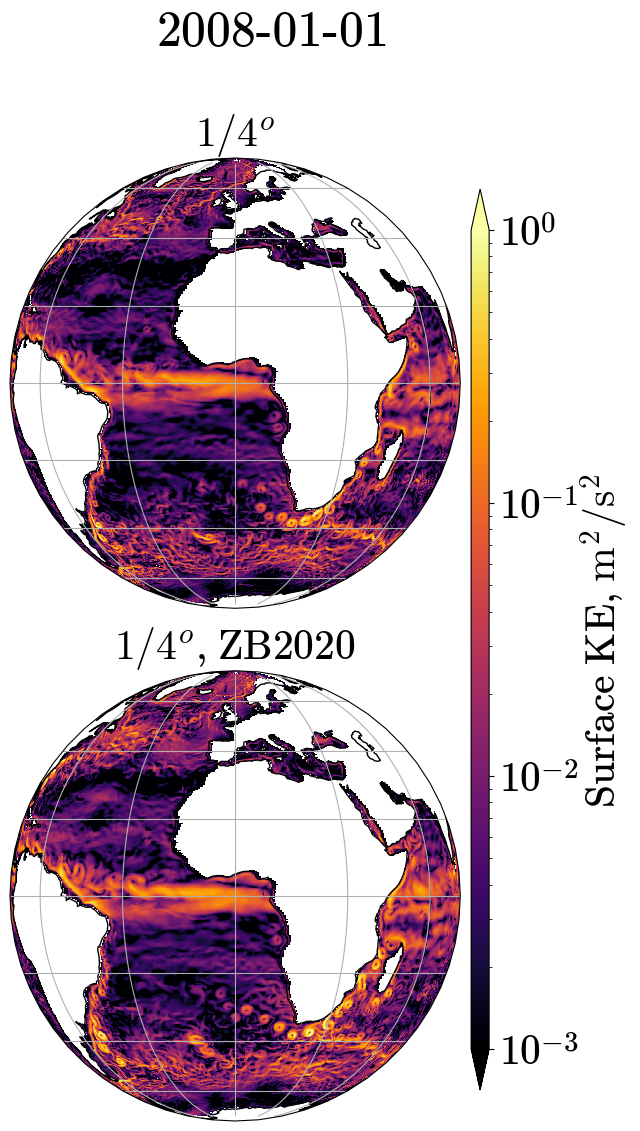

In [7]:
plot()

In [8]:
create_animation(plot, range(0,360), 'site-visit/global-ZB2020.gif', deezering=False, dpi=100, FPS=20)

Animation at FPS=20 will last for 18.0 seconds


In [34]:
default_rcParams({'figure.subplot.hspace': 0.05, 'font.size': 30})
def plot_regions(idx=0, lat=slice(15,70), lon=slice(-100,0)):
    fig, axes = plt.subplots(2,1, figsize=(7, 13), 
    subplot_kw={'projection': ccrs.Orthographic(central_latitude=(lat.start+lat.stop)/2, central_longitude=(lon.start+lon.stop)/2)})
    
    time_idx = idx # sampling every day
    time_str = loreske.time.isel(time=time_idx).item().strftime('%Y-%m-%d')

    ax = axes[0]
    #ax.coastlines(resolution='110m')
    ax.gridlines()
    im = loreske.isel(time=time_idx).sel(xh=lon, yh=lat).plot(
        ax=ax, transform=ccrs.PlateCarree(),
        norm=mpl.colors.LogNorm(vmin=1e-3, vmax=1e+0),
        cmap='inferno',
        add_colorbar=False
    )
    ax.set_title('$1/4^o$', fontsize=30)

    ax = axes[1]
    #ax.coastlines(resolution='110m')
    ax.gridlines()
    im = ZBke.isel(time=time_idx).sel(xh=lon, yh=lat).plot(
        ax=ax, transform=ccrs.PlateCarree(),
        norm=mpl.colors.LogNorm(vmin=1e-3, vmax=1e+0),
        cmap='inferno',
        add_colorbar=False
    )
    ax.set_title('$1/4^o$, ZB2020', fontsize=30)

    cb = plt.colorbar(im, pad=0.02, ax=axes, extend='both', aspect=50, shrink=0.9)
    cb.set_label(label='Surface KE, $\mathrm{m}^2/\mathrm{s}^2$', fontsize=30)
    plt.suptitle(time_str)

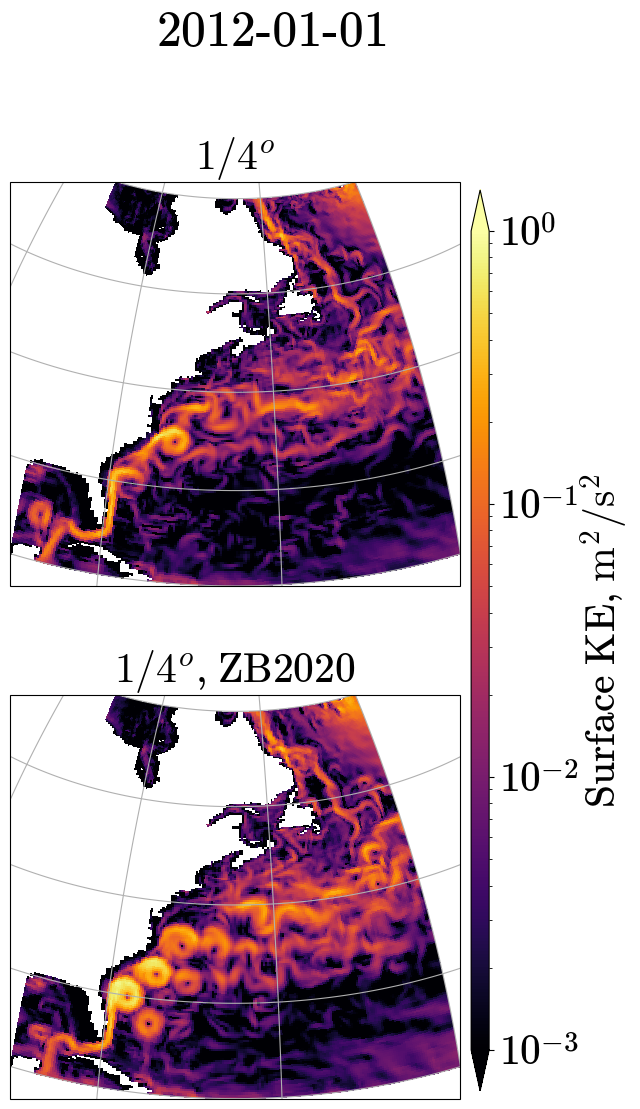

In [35]:
plot_Atlantic = lambda idx: plot_regions(idx=idx, lat=slice(20,60), lon=slice(-90,-40))
plot_Atlantic(1461)
#plot_Atlantic(1826)

In [21]:
create_animation(plot_Atlantic, range(1461,1826,3), 'site-visit/global-ZB2020-Atlantic.gif', deezering=False, dpi=100, FPS=20)

Animation at FPS=20 will last for 6.1 seconds


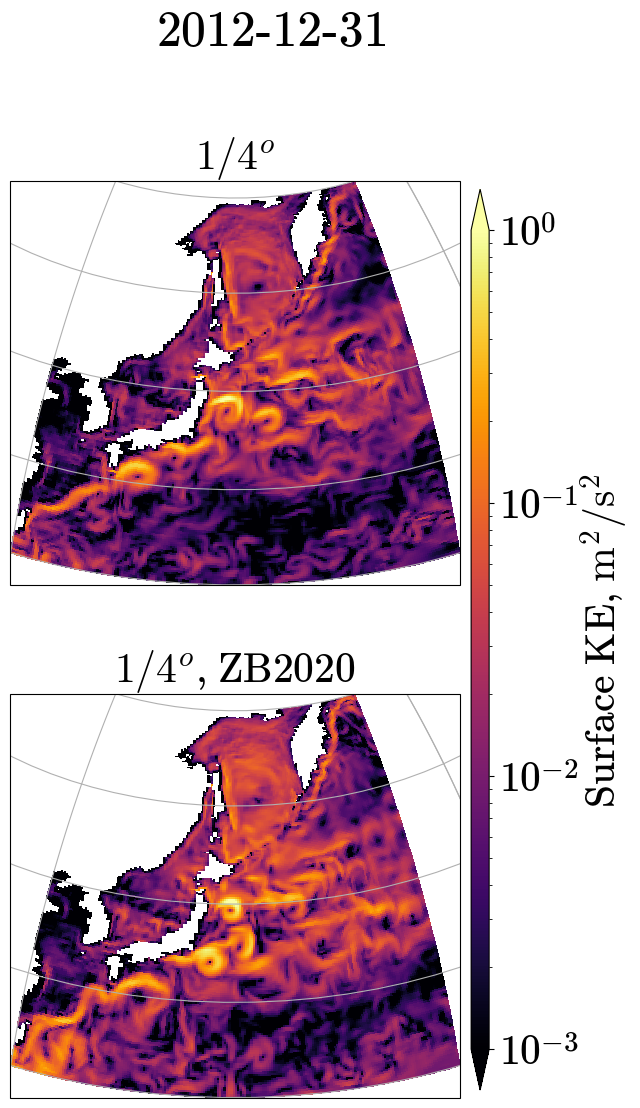

In [19]:
plot_Pacific = lambda idx: plot_regions(idx=idx, lat=slice(20,60), lon=slice(-240,-190))
plot_Pacific(-1)

In [22]:
create_animation(plot_Pacific, range(1461,1826,3), 'site-visit/global-ZB2020-Pacific.gif', deezering=False, dpi=100, FPS=20)

Animation at FPS=20 will last for 6.1 seconds


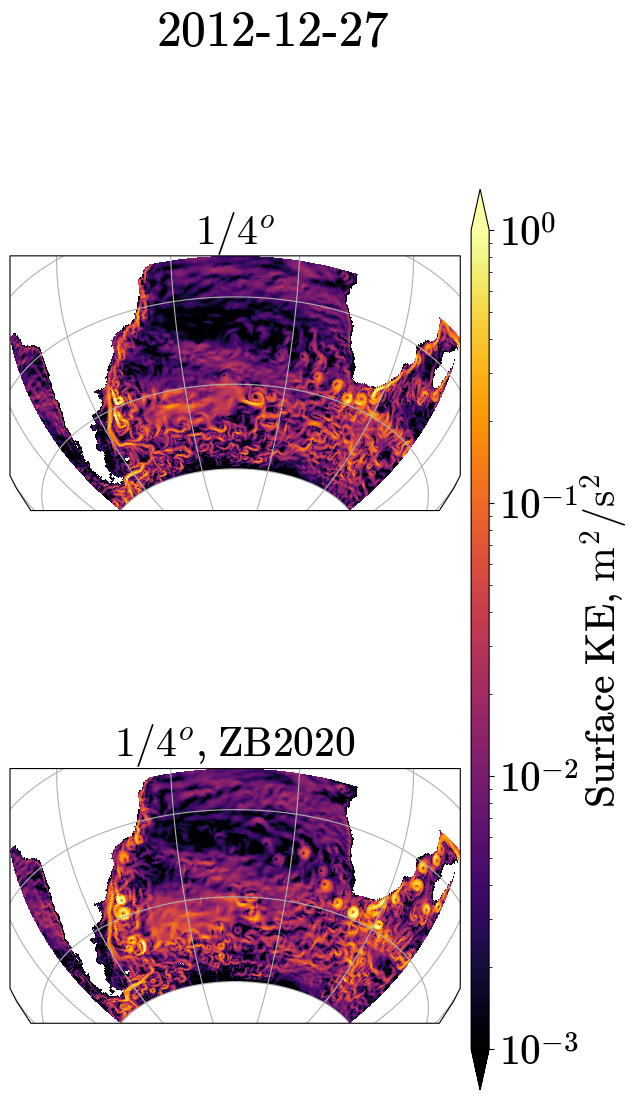

In [11]:
plot_Aghulas_Double = lambda idx: plot_regions(idx=idx, lat=slice(-60,-10), lon=slice(-80,50))
plot_Aghulas_Double(-1)

In [23]:
create_animation(plot_Aghulas_Double, range(292,364), 'site-visit/global-ZB2020-Aghulas_Double.gif', deezering=False, dpi=100, FPS=20)

Animation at FPS=20 will last for 3.6 seconds


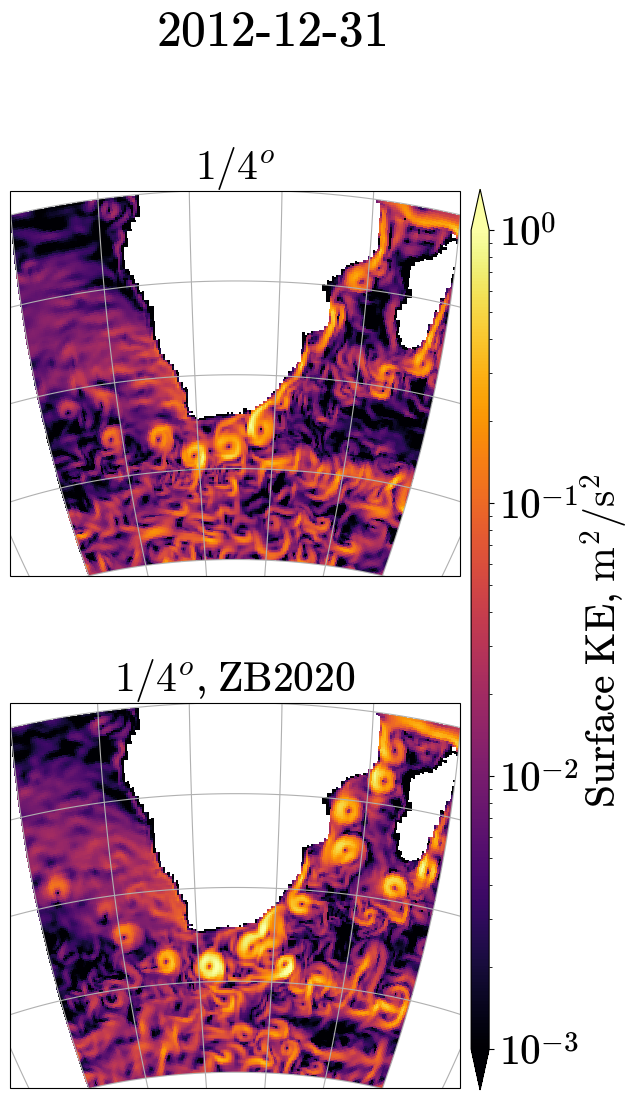

In [23]:
plot_Aghulas = lambda idx: plot_regions(idx=idx, lat=slice(-50,-10), lon=slice(0,50))
plot_Aghulas(-1)

In [24]:
create_animation(plot_Aghulas, range(1461,1826,3), 'site-visit/global-ZB2020-Aghulas.gif', deezering=False, dpi=100, FPS=20)

Animation at FPS=20 will last for 6.1 seconds


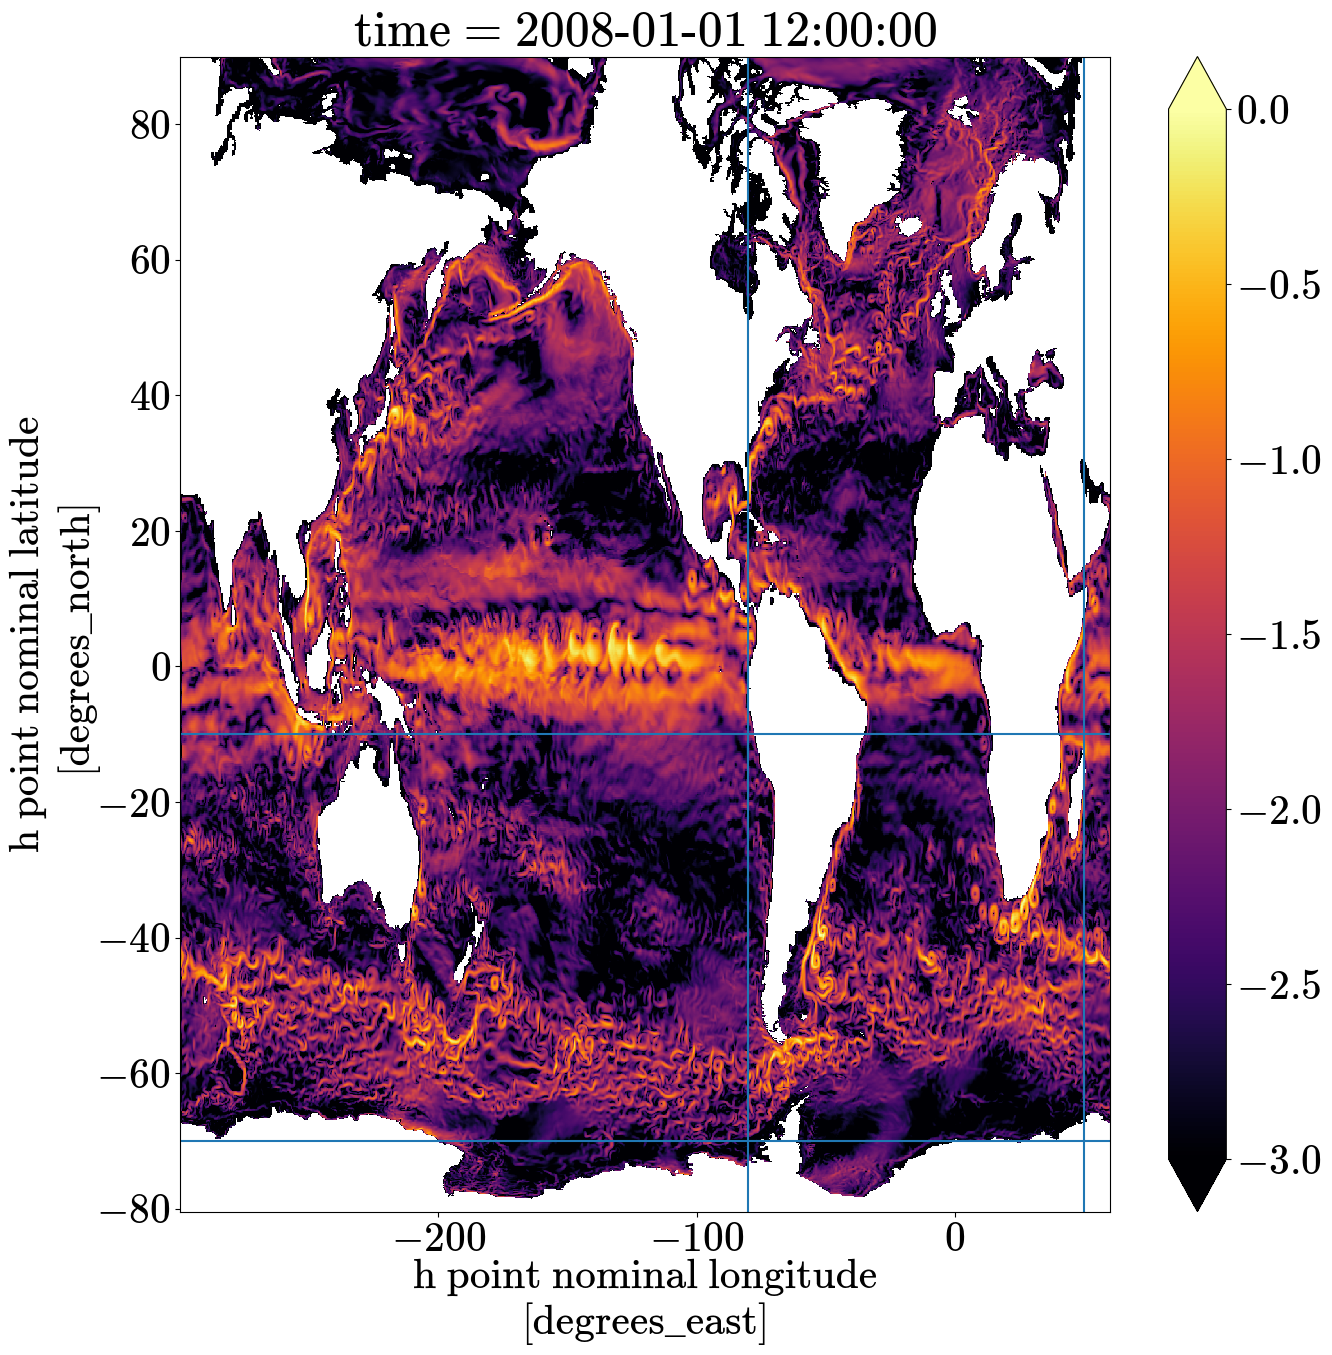

In [136]:
plt.figure(figsize=(15,15))
np.log10(loreske.isel(time=0)).plot(cmap='inferno', vmin=-3,vmax=0)
plt.axvline(x=-80)
plt.axvline(x=50)
plt.axhline(y=-70)
plt.axhline(y=-10)

# Merging gifs

In [25]:
merge_gifs(['site-visit/global-ZB2020-Atlantic.gif', 'site-visit/global-ZB2020-Pacific.gif', 'site-visit/global-ZB2020-Aghulas.gif'],'site-visit/global-ZB2020-merged.gif')

Merged 3 GIFs into site-visit/global-ZB2020-merged.gif


# Check accuracy of geostrophic velocities

In [2]:
from xgcm import Grid
def geostrophic_velocity(ds, ssh):
    '''
    ds contains coordinate information (xh, yh, xq, yq)
    ssh is an array in xh, yh points
    '''
    res = ds.xh[1] - ds.xh[0]
    grid = Grid(ds.drop_vars('time'), coords={
            'X': {'center': 'xh', 'right': 'xq'},
            'Y': {'center': 'yh', 'right': 'yq'}
            },
            periodic = 'X'
            )
    
    R = 6.371e+6 # Earth radius in metres|
    deg_to_rad = np.pi / 180 # degrees to radians factor
    dx = res * R * deg_to_rad * np.cos(ds.yh * deg_to_rad)
    dy = res * R * deg_to_rad
    g = 9.8
    Omega = 7.2921e-5
    fh = 2 * Omega * np.sin(ds.yh * deg_to_rad)
    fq = 2 * Omega * np.sin(ds.yq * deg_to_rad)
    
    # Gradient of the SSH
    hx = grid.diff(ssh, 'X') / dx
    hy = grid.diff(ssh, 'Y') / dy
    
    u = grid.interp(- g / fq * hy, 'Y')
    v = grid.interp(+ g / fh * hx, 'X')
    return u, v

In [3]:
obs = xr.open_dataset('/scratch/ff2183/causal_sea_level/data/Altimetry/altimetry/altimetry.nc', chunks={'time':1}).rename({'longitude': 'xh', 'latitude': 'yh'})
res = 0.25
xq = np.array(obs['xh'] + res / 2)
obs['xq'] = xr.DataArray(xq, dims='xq', coords={'xq': xq})

yq = np.array(obs['yh'] + res / 2)
obs['yq'] = xr.DataArray(yq, dims='yq', coords={'yq': yq})
ug, vg = geostrophic_velocity(obs, obs.adt)

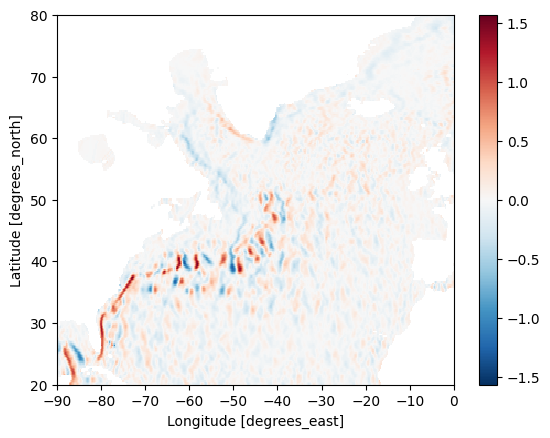

In [4]:
vg.sel(xh=slice(-90,0), yh=slice(20,80)).isel(time=-1).plot()

In [5]:
ZBu = xr.open_dataset('/vast/pp2681/ZB2020/ocean_daily.20080101-20121231.ssu.nc', chunks={'time':1}).ssu
ZBv = xr.open_dataset('/vast/pp2681/ZB2020/ocean_daily.20080101-20121231.ssv.nc', chunks={'time':1}).ssv
ZBh = xr.open_dataset('/vast/pp2681/ZB2020/ocean_daily.20080101-20121231.zos.nc', chunks={'time':1}).zos
loresh = xr.open_dataset('/vast/pp2681/unparameterized/ocean_daily.20080101-20121231.zos.nc', chunks={'time':1}).zos

In [6]:
ZBssh = ZBh.interp(xh=obs.xh, yh=obs.yh)
lores_ssh = loresh.interp(xh=obs.xh, yh=obs.yh)

In [7]:
ZBug, ZBvg = geostrophic_velocity(obs, ZBssh)
loresug, loresvg = geostrophic_velocity(obs, lores_ssh)

In [8]:
ZBkeg = (ZBug**2 + ZBvg**2) * 0.5
loreskeg = (loresug**2 + loresvg**2) * 0.5
obskeg = (ug**2 + vg**2) * 0.5

ZBkeg['time'] = ZBh['time']
loreskeg['time'] = loresh['time']
obskeg['time'] = obs['time']

In [9]:
ZBuint = ZBu.interp(xq=obs.xh, yh=obs.yh)
ZBvint = ZBv.interp(xh=obs.xh, yq=obs.yh)

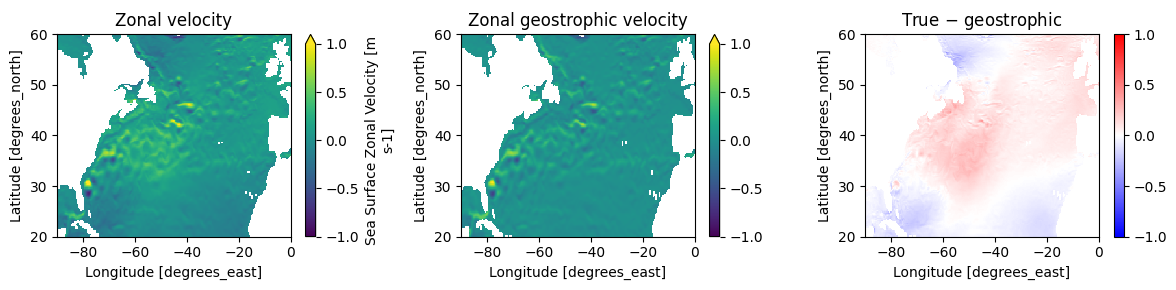

In [10]:
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
ZBuint.sel(xh=slice(-90,0), yh=slice(20,60)).isel(time=-1).plot(vmin=-1,vmax=1)
plt.title('Zonal velocity')
plt.subplot(1,3,2)
ZBug.sel(xh=slice(-90,0), yh=slice(20,60)).isel(time=-1).plot(vmin=-1,vmax=1)
plt.title('Zonal geostrophic velocity')
plt.subplot(1,3,3)
(ZBuint-ZBug).sel(xh=slice(-90,0), yh=slice(20,60)).isel(time=-1).plot(vmin=-1,vmax=1, cmap='bwr')
plt.title('True $-$ geostrophic')
plt.tight_layout()

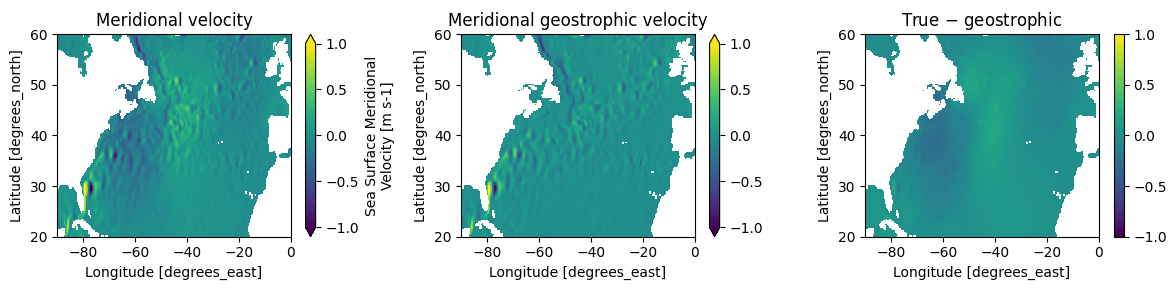

In [11]:
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
ZBvint.sel(xh=slice(-90,0), yh=slice(20,60)).isel(time=-1).plot(vmin=-1,vmax=1)
plt.title('Meridional velocity')
plt.subplot(1,3,2)
ZBvg.sel(xh=slice(-90,0), yh=slice(20,60)).isel(time=-1).plot(vmin=-1,vmax=1)
plt.title('Meridional geostrophic velocity')
plt.subplot(1,3,3)
(ZBvint-ZBvg).sel(xh=slice(-90,0), yh=slice(20,60)).isel(time=-1).plot(vmin=-1,vmax=1)
plt.title('True $-$ geostrophic')
plt.tight_layout()

# Plotting KE

## Selecting 2012 year

In [187]:
OBS_vg = np.sqrt(2*obskeg.isel(time=slice(5478,7305)))
ZB_vg = np.sqrt(2*ZBkeg)
LORES_vg = np.sqrt(2*loreskeg)

In [188]:
default_rcParams({'figure.subplot.wspace': 0.1, 'font.size': 20})
def plot_regions(idx=0, lat=slice(20,70), lon=slice(-90,0)):
    fig, axes = plt.subplots(1,3, figsize=(12, 4), 
    subplot_kw={'projection': ccrs.Orthographic(central_latitude=(lat.start+lat.stop)/2, central_longitude=(lon.start+lon.stop)/2)})
    
    time_idx=idx
    time_str = LORES_vg.time.isel(time=time_idx).item().strftime('%Y-%m-%d')
    
    # My preset; Equivalent to plotting surface KE
    cmap = plt.get_cmap('inferno')
    norm = mpl.colors.LogNorm(vmin=0.05, vmax=1.5)
    # Julius preset
    #cmap = plt.get_cmap('BuPu')
    #norm = mpl.colors.LogNorm(vmin=10**(-1.5), vmax=10**(0.5))
    cmap.set_bad('gray')
    
    ax = axes[0]
    ax.coastlines()
    ax.gridlines()
    im = LORES_vg.isel(time=time_idx).sel(xh=lon, yh=lat).plot(
        ax=ax, transform=ccrs.PlateCarree(),
        norm=norm,
        cmap=cmap,
        add_colorbar=False
    )
    ax.set_title('OM4 ($1/4^o$)', fontsize=30)

    ax = axes[1]
    ax.coastlines()
    ax.gridlines()
    im = ZB_vg.isel(time=time_idx).sel(xh=lon, yh=lat).plot(
        ax=ax, transform=ccrs.PlateCarree(),
        norm=norm,
        cmap=cmap,
        add_colorbar=False
    )
    ax.set_title('ZB20', fontsize=30)
    
    ax = axes[2]
    ax.coastlines()
    ax.gridlines()
    im = OBS_vg.isel(time=time_idx).sel(xh=lon, yh=lat).plot(
        ax=ax, transform=ccrs.PlateCarree(),
        norm=norm,
        cmap=cmap,
        add_colorbar=False
    )
    ax.set_title('Altimetry', fontsize=30)


    cb = plt.colorbar(im, pad=0.02, ax=axes, extend='both', aspect=100, shrink=1.0, orientation='horizontal')
    cb.set_label(label='Surface geostrophic velocity, $\mathrm{m}/\mathrm{s}$')
    plt.suptitle(time_str, y=0.95)

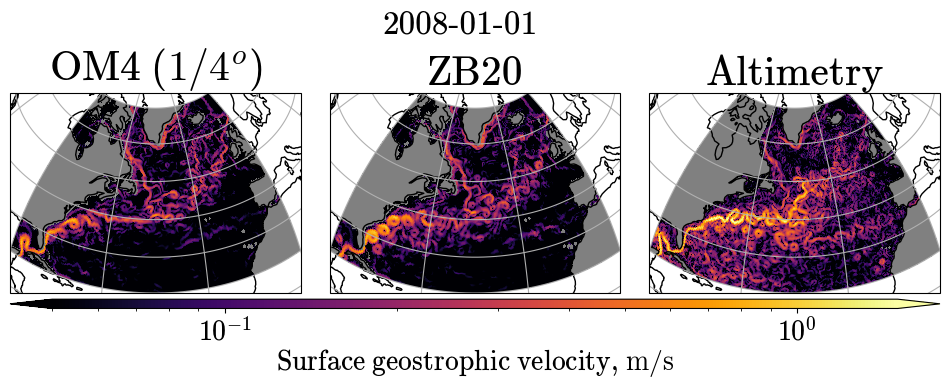

In [189]:
plot_Atlantic = lambda idx: plot_regions(idx=idx)
plot_Atlantic(0)

In [192]:
%%time
create_animation(plot_Atlantic, range(0,1827,3), 'site-visit/geovel.gif', deezering=False, dpi=300, FPS=20)

Animation at FPS=20 will last for 30.45 seconds
CPU times: user 19min 6s, sys: 11min 14s, total: 30min 21s
Wall time: 17min 38s


In [200]:
split_gif('site-visit/geovel.gif', 'site-visit/geovel', 5)

Segment 0 saved as site-visit/geovel/segment_0.gif
Segment 1 saved as site-visit/geovel/segment_1.gif
Segment 2 saved as site-visit/geovel/segment_2.gif
Segment 3 saved as site-visit/geovel/segment_3.gif
Segment 4 saved as site-visit/geovel/segment_4.gif
Split site-visit/geovel.gif into 5 segments
